# Lazy Predict for regression

In [1]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
import numpy as np
import lazypredict
import matplotlib.pyplot as plt
import seaborn as sns
import random

#from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

## Set random seed for reproducibility

In [2]:
SEED = 64

#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Loading

In [55]:
# Only modify this
file_name = "california_housing"

In [50]:
df = pd.read_csv(f'../Datasets_benchmark/{file_name}.csv')

In [51]:
# Display the first few rows of the dataframe
print(df.head())

# Display the dataframe's information (column types, non-null values, etc.)
print(df.info())

# Get the number of rows and columns
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

   NU_IDADE_N  CS_SEXO  CS_GESTANT  CS_RACA  CS_ZONA  FEBRE  MIALGIA  \
0     4022.00        0        5.00     1.00     3.00   1.00     1.00   
1     4020.00        1        6.00     4.00     1.00   1.00     1.00   
2     4061.00        0        6.00     4.00     1.00   1.00     1.00   
3     4046.00        1        6.00     4.00     1.00   1.00     1.00   
4     4014.00        1        6.00     4.00     1.00   1.00     1.00   

   CEFALEIA  EXANTEMA  VOMITO  ...  DOR_RETRO  DIABETES  HEMATOLOG  HEPATOPAT  \
0      1.00      2.00    2.00  ...       1.00      2.00       2.00       2.00   
1      1.00      2.00    2.00  ...       2.00      2.00       2.00       2.00   
2      1.00      2.00    2.00  ...       2.00      2.00       2.00       2.00   
3      1.00      2.00    2.00  ...       2.00      2.00       2.00       2.00   
4      1.00      2.00    1.00  ...       1.00      2.00       2.00       2.00   

   RENAL  HIPERTENSA  ACIDO_PEPT  AUTO_IMUNE  DIAS   CLASSI_FIN  
0   2.00      

In [6]:
# Summary statistics for numerical columns
print(df.describe())

# For categorical columns if any
#print(df.describe(include='object'))

        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
count 20640.00  20640.00  20640.00   20640.00    20640.00  20640.00  20640.00   
mean      3.87     28.64      5.43       1.10     1425.48      3.07     35.63   
std       1.90     12.59      2.47       0.47     1132.46     10.39      2.14   
min       0.50      1.00      0.85       0.33        3.00      0.69     32.54   
25%       2.56     18.00      4.44       1.01      787.00      2.43     33.93   
50%       3.53     29.00      5.23       1.05     1166.00      2.82     34.26   
75%       4.74     37.00      6.05       1.10     1725.00      3.28     37.71   
max      15.00     52.00    141.91      34.07    35682.00   1243.33     41.95   

       Longitude  MedHouseVal  
count   20640.00     20640.00  
mean     -119.57         2.07  
std         2.00         1.15  
min      -124.35         0.15  
25%      -121.80         1.20  
50%      -118.49         1.80  
75%      -118.01         2.65  
max      -114.

In [7]:
# Check for missing values
print(df.isnull().sum())

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


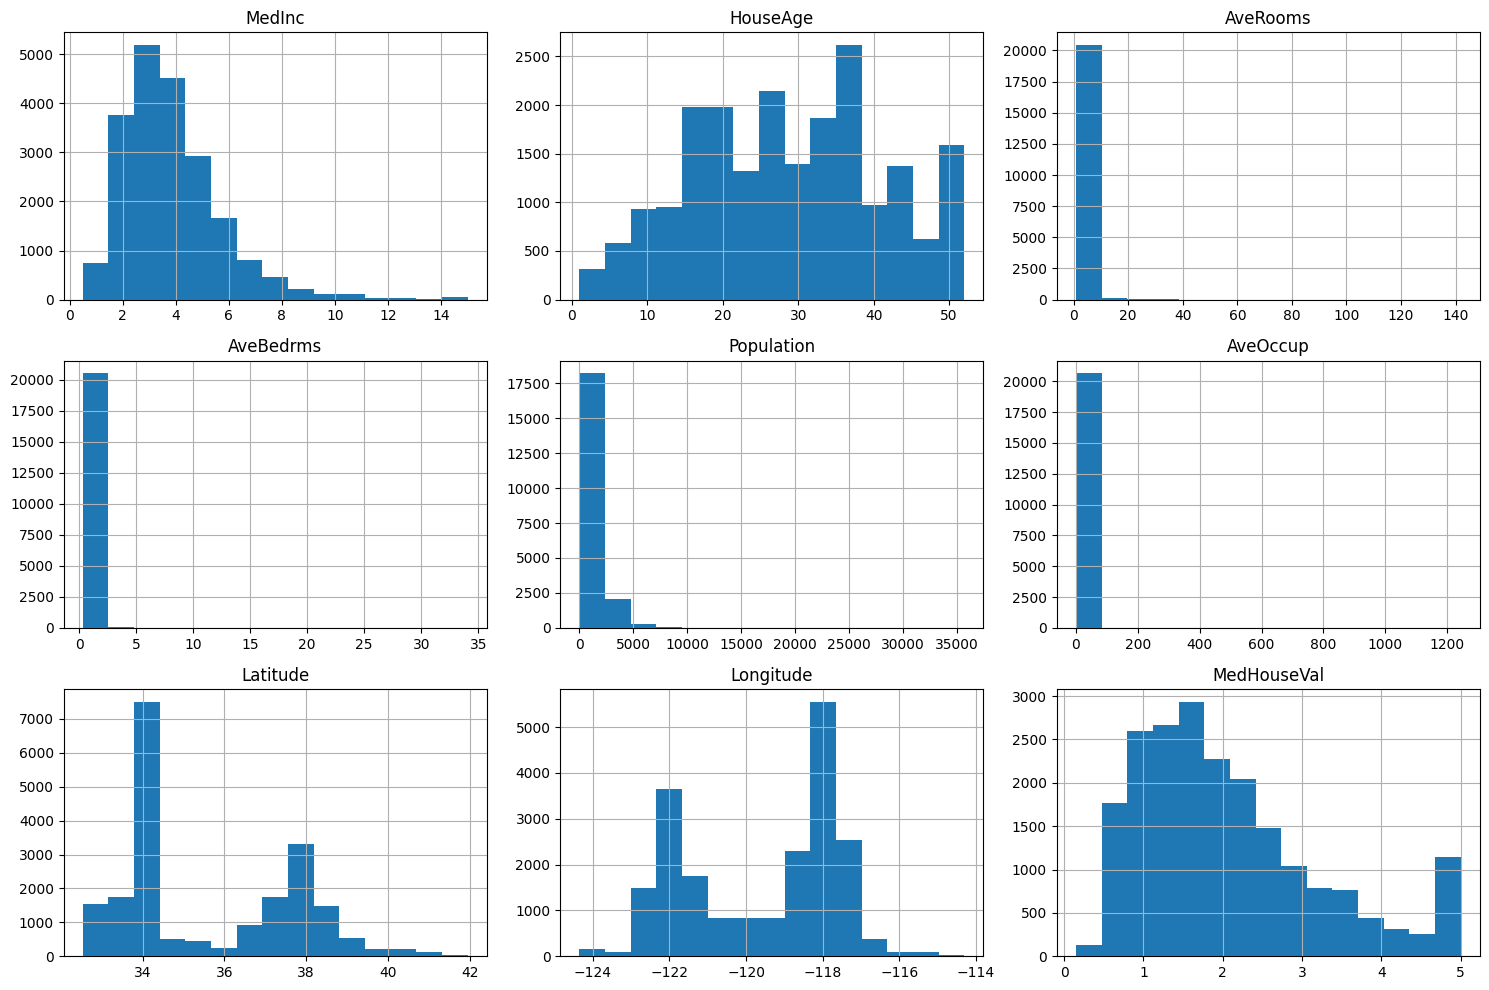

In [8]:
# Histograms for numerical data
df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

## Data Preprocessing

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.iloc[:,:-1]

X = scaler.fit_transform(X)
X

array([[ 2.34476576,  0.98214266,  0.62855945, ..., -0.04959654,
         1.05254828, -1.32783522],
       [ 2.33223796, -0.60701891,  0.32704136, ..., -0.09251223,
         1.04318455, -1.32284391],
       [ 1.7826994 ,  1.85618152,  1.15562047, ..., -0.02584253,
         1.03850269, -1.33282653],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ..., -0.0717345 ,
         1.77823747, -0.8237132 ],
       [-1.05458292, -0.84539315, -0.04021111, ..., -0.09122515,
         1.77823747, -0.87362627],
       [-0.78012947, -1.00430931, -0.07044252, ..., -0.04368215,
         1.75014627, -0.83369581]])

In [10]:
y = df.iloc[:,-1]
y

0       4.53
1       3.58
2       3.52
3       3.41
4       3.42
        ... 
20635   0.78
20636   0.77
20637   0.92
20638   0.85
20639   0.89
Name: MedHouseVal, Length: 20640, dtype: float64

In [11]:
from sklearn.model_selection import KFold

In [12]:
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=SEED, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

In [14]:
y_val

4941    0.97
13355   1.60
6397    2.76
13023   1.33
9951    2.68
        ... 
10673   5.00
14715   2.49
880     2.70
17955   3.16
16180   0.53
Name: MedHouseVal, Length: 4128, dtype: float64

## Model Architecture (Lazy Predict)

In [15]:
#lazypredict.supervised.REGRESSORS = lazypredict.supervised.REGRESSORS[33:36]
#lazypredict.supervised.REGRESSORS

In [16]:
LazyRegressor

lazypredict.Supervised.LazyRegressor

In [17]:
clf = LazyRegressor(verbose=2, ignore_warnings=True, custom_metric=None)

## Model Training

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

In [19]:
models = []
predictions = []

In [ ]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model, prediction = clf.fit(X_train, X_val, y_train, y_val)
    models.append(model)
    predictions.append(prediction)

In [34]:
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

TypeError: Cannot clone object '<lazypredict.Supervised.LazyRegressor object at 0x000002007F955390>' (type <class 'lazypredict.Supervised.LazyRegressor'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

## Model Evaluation

In [33]:
all_predictions = pd.concat(predictions[0:5], keys=range(5))

In [34]:
all_predictions

Adjusted R-Squared  R-Squared  RMSE  \
  Model                                                                
0 LGBMRegressor                                0.84       0.84  0.47   
  HistGradientBoostingRegressor                0.84       0.84  0.47   
  XGBRegressor                                 0.83       0.83  0.48   
  ExtraTreesRegressor                          0.81       0.81  0.50   
  RandomForestRegressor                        0.81       0.81  0.50   
...                                             ...        ...   ...   
4 RANSACRegressor                             -0.83      -0.83  1.56   
  KernelRidge                                 -2.64      -2.64  2.20   
  PassiveAggressiveRegressor                  -6.48      -6.47  3.15   
  SGDRegressor                              -245.07    -244.60 18.08   
  GaussianProcessRegressor                 -3084.07   -3078.09 64.01   

                                 Time Taken  
  Model                                      
0 LGBMRegressor                        0.26  
  HistGradientBoostingRegressor        1.04  
  XGBRegressor                         0.20  
  ExtraTreesRegressor                  3.00  
  RandomForestRegressor                8.96  
...                                     ...  
4 RANSACRegressor                      0.09  
  KernelRidge                         20.84  
  PassiveAggressiveRegressor           0.02  
  SGDRegressor                         0.02  
  GaussianProcessRegressor            34.83  

[210 rows x 4 columns]

In [52]:

# Concatenate the predictions DataFrames vertically
all_predictions = pd.concat(predictions[0:5], keys=range(5))

# Reset the index to make the fold number a regular column
all_predictions = all_predictions.reset_index(level=0)

# Rename the level_0 column to 'Fold'
all_predictions = all_predictions.rename(columns={'level_0': 'Fold'})

# Group by the model names and calculate the mean value for each metric across all folds
avg_metrics = all_predictions.groupby(all_predictions.index).mean()

# Sort the avg_metrics DataFrame by the "RMSE" column in ascending order
avg_metrics = avg_metrics.sort_values('RMSE')

# Reset the index to make the model names a regular column
avg_metrics = avg_metrics.reset_index()

# Display the resulting DataFrame
avg_metrics

,Model,Fold,Adjusted R-Squared,R-Squared,RMSE,Time Taken
0,LGBMRegressor,2.00,0.84,0.84,0.47,0.27
1,HistGradientBoostingRegressor,2.00,0.83,0.83,0.47,1.07
2,XGBRegressor,2.00,0.83,0.83,0.47,0.26
3,ExtraTreesRegressor,2.00,0.81,0.81,0.50,3.04
4,RandomForestRegressor,2.00,0.81,0.81,0.50,9.05
5,GradientBoostingRegressor,2.00,0.79,0.79,0.53,2.96
6,BaggingRegressor,2.00,0.79,0.79,0.53,0.89
7,MLPRegressor,2.00,0.78,0.78,0.55,7.05
8,NuSVR,2.00,0.74,0.74,0.59,10.47
9,SVR,2.00,0.74,0.74,0.59,8.82


In [58]:
# Concatenate the predictions DataFrames vertically
all_predictions = pd.concat(predictions[0:5], keys=range(5))

# Reset the index to make the fold number a regular column
all_predictions = all_predictions.reset_index(level=0)

# Rename the level_0 column to 'Fold'
all_predictions = all_predictions.rename(columns={'level_0': 'Fold'})

# Define a custom function to calculate mean and standard deviation
def mean_std(x):
    return f"{np.mean(x):.3f}±{np.std(x):.3f}"

# Group by the model names and calculate the mean and standard deviation of RMSE
avg_metrics = all_predictions.groupby(all_predictions.index)['RMSE'].agg(mean_std)

# Sort the avg_metrics Series by the RMSE values
avg_metrics = avg_metrics.sort_values()

# Reset the index to make the model names a regular column
avg_metrics = avg_metrics.reset_index()

# Rename the 'RMSE' column to 'RMSE (Mean±Std)'
avg_metrics = avg_metrics.rename(columns={'RMSE': 'RMSE (Mean±Std)'})

# Display the resulting DataFrame
avg_metrics

,Model,RMSE (Mean±Std)
0,LGBMRegressor,0.466±0.013
1,HistGradientBoostingRegressor,0.469±0.011
2,XGBRegressor,0.470±0.011
3,ExtraTreesRegressor,0.499±0.012
4,RandomForestRegressor,0.503±0.014
5,GradientBoostingRegressor,0.533±0.012
6,BaggingRegressor,0.533±0.017
7,MLPRegressor,0.546±0.014
8,NuSVR,0.585±0.012
9,SVR,0.587±0.011


In [56]:
# Convert results into a DataFrame
test_results = pd.DataFrame(avg_metrics)

In [57]:
# Save to a text file
test_results.to_csv(f'model_results/{file_name}_results_k_fold.txt', index=True)